### Parking Analysis

#### Values
- Spaces
- Cost

#### Segments
- pricing:
  - paid
  - free
- rate:
  - hourly
  - daily
  - monthly
- location:
  - on-street
  - off-street
- ownership:
  - public
  - private
- tod:
  - business hours
  - non-business hours

Not all segments fully cross with eachother, should collapose some segments to make a flattened data frame.

### Desired structure
We do not need all the different segments. Just a dataframe with the following fields for each MGRA:

- Weighted average cost of private and public parking, assuming weight is n-spaces $= \frac{(n_{private} * cost_{private} + n_{public} * cost_{public})}{n_{private} + n_{public}}$
- Sum of public and private spaces
- Max cost for business hours or after hours

### Some assumptions
- Collapse on-street/off-street segment
  - assuming all on-street are "public"
  - assume that off-street residential are "free" 
  - assume that public space counts are inclusive of private space count
- Reduce business hours and after hours by selecting the max value
  - assume peak pricing is most critical in daily pricing
  - assume there are no $0 costs in inventory, otherwise they would be considered free spaces or NaN
  - assume max daily on-street period is 10 hours (8am to 6pm)?


### Consolidation -- collapsing segments

From the assumptions, the data can be reduced to the following:

- free_spaces = on_street_free_spaces + off_street_free_spaces + off_street_residential_spaces
- paid_space = on_street_paid_spaces + off_street_paid_private_spaces
- hourly_cost = (
    on_street_paid_spaces * argmax(on_street_hourly_cost_during_business, on_street_hourly_cost_after_business) + 
    off_street_paid_public_spaces * argmax(off_street_paid_public_hourly_cost_during_business, off_street_paid_public_hourly_cost_after_business) +
    off_street_paid_private_spaces * argmax(off_street_paid_private_hourly_cost_during_business, off_street_paid_private_hourly_cost_after_business)
    ) / (on_street_paid_spaces + off_street_paid_public_spaces + off_street_paid_private_spaces)
- daily_cost = (off_street_paid_public_spaces * off_street_paid_public_daily_cost + off_street_paid_private_spaces * off_street_paid_private_daily_cost) / (off_street_paid_public_spaces + off_street_paid_private_spaces)
- monthly_cost = (off_street_paid_public_spaces * off_street_paid_public_monthly_cost +  off_street_paid_private_spaces * off_street_paid_private_monthly_cost) / (off_street_paid_public_spaces + off_street_paid_private_spaces)

NAs are skipped so that an average is calculated if there is at least one available value. If all are NA, the NA is preserved for imputation.

Even after reduction, there are many NAs that will need to be imputed. Some options:
- establishing a function from hourly to daily/monthly
- predict from land use data
- combination of the two

In [231]:
import sys
import importlib
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm 
import random
import folium
from parking.expected_cost import ExpectedParkingCost
from parking.reduction import parking_reduction
from parking.districts import get_parking_districts
from parking.imputation import ImputeParkingCosts

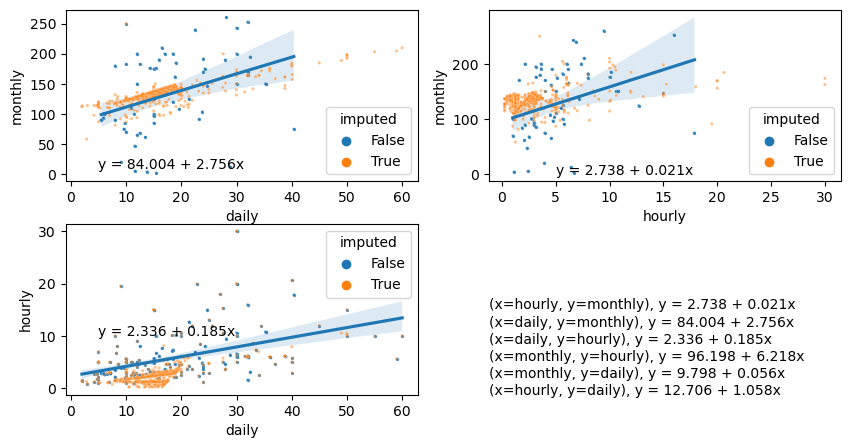

In [3]:
importlib.reload(sys.modules['parking.reduction'])
importlib.reload(sys.modules['parking.imputation'])
from parking.reduction import parking_reduction
from parking.imputation import ImputeParkingCosts

# Read MGRA data
gdf_mgra = gpd.read_file('data/mgra15/mgra15.shp').set_index('MGRA')

## Reduce parking data
parking_df = pd.read_csv('data/mgra_parking_inventory.csv').set_index('mgra')
lu_df = pd.read_csv("data/land_use.csv").set_index("mgra")

# Get reduced parking data set
reduced_df = parking_reduction(parking_df)
reduced_df.to_csv('output/consolidated_costs.csv')

# Impute missing values
IPC = ImputeParkingCosts()
imputed_df = IPC.impute(reduced_df, lu_df)

# Save output
imputed_df.to_csv("output/imputed_costs.csv")

In [4]:
# Test if paid offstreet private spaces is always larger than paid offstreet public spaces. 
# display(Impute.parking_df[['off_street_paid_private_spaces','off_street_paid_public_spaces']].head())
# all((Impute.parking_df.off_street_paid_private_spaces - Impute.parking_df.off_street_paid_public_spaces).fillna(0) >= 0)

# Summaries
print(f"Total zones with data {len(reduced_df.index)} out of {len(lu_df.index)}")
print(f"Any missing space counts: {reduced_df[['paid_spaces', 'free_spaces']].isnull().any().any()}")

print(f"N-Hourly: {len(reduced_df[['hourly']].dropna().index)}")
print(f"N-Daily: {len(reduced_df[['daily']].dropna().index)}")
print(f"N-Monthly: {len(reduced_df[['monthly']].dropna().index)}")
print(f"N-Hourly&Daily: {len(reduced_df[['hourly', 'daily']].dropna().index)}")
print(f"N-Daily&Monthly: {len(reduced_df[['monthly', 'daily']].dropna().index)}")
print(f"N-Hourly&Monthly: {len(reduced_df[['hourly', 'monthly']].dropna().index)}")
print(f"N-Hourly&Daily&Monthly: {len(reduced_df[['hourly', 'daily', 'monthly']].dropna().index)}")

df = (~reduced_df[['hourly', 'daily', 'monthly']].isnull()).astype(int)
# tmp = pd.crosstab(index=[tmp.hourly, tmp.daily, tmp.monthly], columns=[tmp.hourly, tmp.daily, tmp.monthly], margins=True, dropna=False)
mat = df.T.dot(df)

mat.loc['Total', :] = mat.sum(axis=0)
mat.loc[:, 'Total'] = mat.sum(axis=1)
display(mat)

Total zones with data 1339 out of 24333
Any missing space counts: False
N-Hourly: 523
N-Daily: 228
N-Monthly: 69
N-Hourly&Daily: 205
N-Daily&Monthly: 67
N-Hourly&Monthly: 67
N-Hourly&Daily&Monthly: 66


,hourly,daily,monthly,Total
hourly,523.0,205.0,67.0,795.0
daily,205.0,228.0,67.0,500.0
monthly,67.0,67.0,69.0,203.0
Total,795.0,500.0,203.0,1498.0


## Find parking "districts"

Three step process:
1. Spatially cluster zones with paid parking based on a maximum distance threshold
2. Create a concave hull for each cluster plus a walking distance buffer around hull
3. Join all zones within that hull


### 1. Clustering
Spatial clustering uses a "Agglomerative Clustering" technique where points are grouped into discrete clusters based on distance.
Inputs:
- affinity matrix: Pre-computed distance between every geometric polygon. The polygon edge-to-edge distance was used, instead of centroids, to provide a more inclusive and conservative clustering measure.
- distance threshold: The maximum distance before a new cluster is created.
- linkage criterion: Which distance to use between observations, in this case "single" distance is used. It can be thought of as the chained distance where the chain is broken and a new cluster is formed when the distance threshold is exceeded:
  - "ward" minimizes the variance of the clusters being merged.
  - "average" uses the average of the distances of each observation of the two sets.
  - "complete" or ‘maximum’ linkage uses the maximum distances between all observations of the two sets.
  - "single" uses the minimum of the distances between all observations of the two sets.

The zones with parking costs can then be grouped together based on the maximum walking distance threshold.

### 2. Concave hull
A convex hull is formed from as the minimum shape that included all points. However, a convex hull is not sensitive to concave or "gerrymandered" shapes. To form a concave shape, the "alpha shape" can be formed using a Delaunay triangulation technique. 

A concave hull can be created by setting the $\alpha$ parameter, which relates to Delaunay triangles where the radii is at most $1/\alpha$. An $\alpha$ of 0 would be the convex hull, and an $\alpha$ of infinity would be the minimum spanning tree of the points. Thus, to set an alpha relative to our space where radii = max_walk_dist then $\alpha$ = 1/max_walk_dist = 1 / (max_dist * 5280)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Delaunay_circumcircles_vectorial.svg/512px-Delaunay_circumcircles_vectorial.svg.png"  width="15%">
<img src="https://doc.cgal.org/latest/Alpha_shapes_2/alphashape.png"  width="15%"><br>

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6a/ScagnosticsBase.svg"  width="40%">


### 3. Spatial join
Once the concave hull is found for each parking cluster, a simple buffer distance equal to the maximum walking distance is added to buffer around the zone to include additional walkable zones. Using the buffered concave hulls, all MGRA zones are spatially joined if they are within the concave hull envelope, forming discrete "paid parking districts".

In [10]:
importlib.reload(sys.modules['parking.districts'])
from parking.districts import get_parking_districts

# analyze districts
district_dict = get_parking_districts(imputed_df, gdf_mgra, max_dist=0.5, plot=True)

parking_districts = district_dict['districts']
parking_hulls = district_dict['hulls']
parking_clusters = district_dict['clusters']

100%|██████████| 780/780 [00:08<00:00, 90.90it/s] 


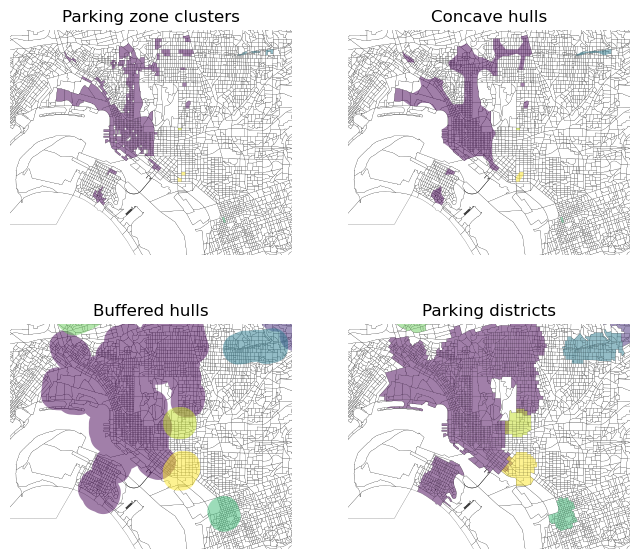

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 7))
for axrow in axes:
    for ax in axrow:
        ax.axis('off')
        gdf_mgra.geometry.plot(color='white', edgecolor='k', linewidth=0.125, ax=ax)
        ax.set_xlim(np.array([6.26, 6.31]) * 1e6)
        ax.set_ylim(np.array([1.82, 1.86])*1e6)
parking_clusters.plot(column='cluster_id', alpha=0.5, ax=axes[0][0], legend=False).set_title('Parking zone clusters')
parking_hulls.geometry.reset_index().plot(column='cluster_id', alpha=0.5, ax=axes[0][1], legend=False).set_title('Concave hulls')
parking_hulls.buffered_geometry.reset_index().plot(column='cluster_id', alpha=0.5, ax=axes[1][0], legend=False).set_title('Buffered hulls')
parking_districts[~parking_districts.cluster_id.isnull()].plot(column='cluster_id', alpha=0.5, ax=axes[1][1], legend=False).set_title('Parking districts')

fig.savefig('./output/clustermethod.png', dpi=800)

# Estimate parking spaces

1. Fetch OSM network
2. Filter out the edges for roads that definitely don't have parking
3. Intersect the network with zones (slice up network into zones)
4. Aggregate road length and intersection count per zone
5. Model the number of on-street spaces values with network aggregate length/intersection counts

Alternative estimation, parking space = ~16ft, thus:
- N = intersections
- L = total street length
- spaces =  4 * ( L / 22  - N)    spaces per length - 4 per intersection

In [11]:
from parking.estimate_spaces import EstimateStreetParking
importlib.reload(sys.modules['parking.estimate_spaces'])

# Initialize estimation
EstSpaces = EstimateStreetParking()

# Aggregate network data to zones
street_data = EstSpaces.get_streetdata(gdf_mgra, './data/agg_streetdata.csv')

In [ ]:
# Get graph and remove highways
if 'G' not in locals():
    G = EstSpaces.get_network(gdf_mgra, path="./data/network.graphml")
H = EstSpaces.filter_network(G)
# street_data = aggregate_streetdata(self, H, gdf_mgra)

# Some futher analysis
# Let's see what kind of road types we have
tmp = [e['highway'] if isinstance(e['highway'], list) else [e['highway']] for u,v,e in G.edges(data=True)]
tmp = [x for sublist in tmp for x in sublist]
tmp = [{'type': x, 'count': tmp.count(x)} for x in set(tmp)]
pd.DataFrame.from_dict(tmp).sort_values('count', ascending=False).reset_index(drop=True)

,type,count
0,residential,154271
1,tertiary,18946
2,secondary,14958
3,primary,5442
4,unclassified,2915
5,motorway_link,2272
6,motorway,1401
7,living_street,768
8,primary_link,398
9,secondary_link,385


### See if a model can be built vs strict calculation

In [12]:
# Some computations
streetparking_df = parking_df.filter(regex='on_street').filter(regex='spaces').sum(axis=1).to_frame('spaces').join(street_data[['length', 'intcount']])
streetparking_df = streetparking_df.join((gdf_mgra.geometry.area / 43560).to_frame('acres'))
streetparking_df = streetparking_df[(streetparking_df.spaces > 0) & (streetparking_df.length > 0)]
streetparking_df['log-length'] = np.log(streetparking_df.length)
streetparking_df['log-acres'] = np.log(streetparking_df.acres)
streetparking_df['log-spaces'] = np.log(streetparking_df.spaces)
streetparking_df['length_per_acre'] = streetparking_df.length / streetparking_df.acres
streetparking_df['int_per_acre'] = streetparking_df.intcount / streetparking_df.acres
streetparking_df['avg_block_length'] = streetparking_df.length / streetparking_df.intcount.clip(1)

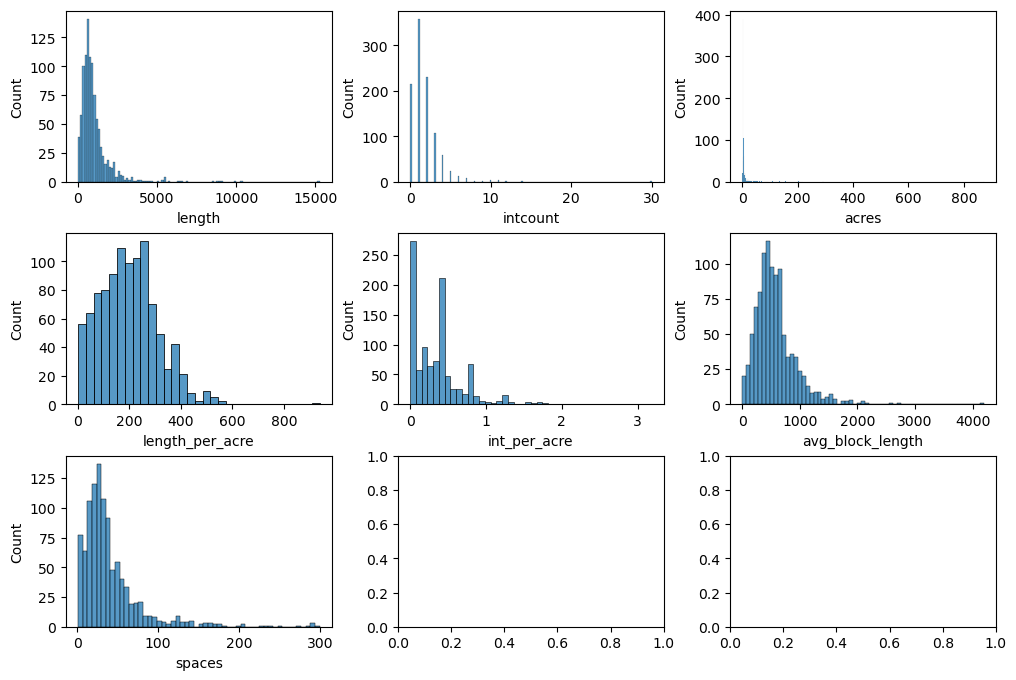

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.25)
plot_vars = [['length', 'intcount', 'acres'],
             ['length_per_acre', 'int_per_acre', 'avg_block_length'],
             ['spaces']]
for i, row in enumerate(plot_vars):
    for j, col in enumerate(row):
        sns.histplot(data=streetparking_df, x=col, ax=axes[i][j])

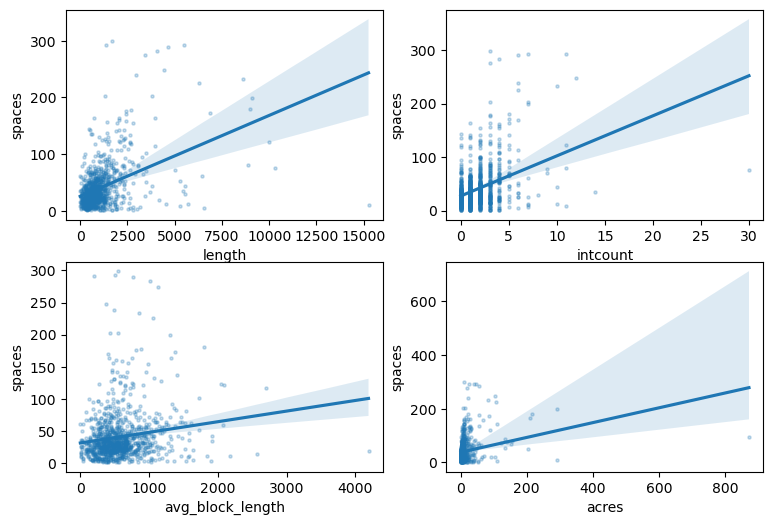

In [ ]:
i, cols = 0, ['length', 'intcount', 'avg_block_length', 'acres'] # {'spaces': ['length', 'intcount'], 'log-spaces': ['length_per_acre', 'int_per_acre']}
fig, axes = plt.subplots(2, 2, figsize=(9, 6))
for axx in axes:
    for ax in axx:
        sns.regplot(data=streetparking_df, y='spaces', x=cols[i], ax=ax, scatter=True, scatter_kws={'s':5, 'alpha':0.25})#.set(xscale='log')
        i += 1

In [15]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy

def MAPE(y, yhat):
    return 100*np.abs((y - yhat) / y).mean()

# f = 'spaces ~ length_per_acre + int_per_acre'
# f = 'spaces ~ 0 + np.sqrt(length) + intcount + np.sqrt(acres)'
f = 'spaces ~ 0 + length + intcount + acres'
# f = 'spaces ~ 0 + length + intcount + acres + avg_block_length'
y, X = patsy.dmatrices(f, streetparking_df, return_type='matrix')

mod_lm = smf.ols(formula=f, data=streetparking_df).fit()
mod_pois = sm.GLM(endog=y, exog=X, family=sm.families.Poisson()).fit()

mod_lm.summary()
# mod_pois.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 spaces   R-squared (uncentered):                   0.522
Model:                            OLS   Adj. R-squared (uncentered):              0.521
Method:                 Least Squares   F-statistic:                              373.4
Date:                Fri, 26 May 2023   Prob (F-statistic):                   8.47e-164
Time:                        08:13:33   Log-Likelihood:                         -5209.2
No. Observations:                1027   AIC:                                  1.042e+04
Df Residuals:                    1024   BIC:                                  1.044e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
length         0.0170      0.002     11.030      0.000       0.014       0.020
intcount       5.9750      0.861      6.940      0.000       4.286       7.664
acres         -0.0090      0.039     -0.229      0.819      -0.086       0.068
==============================================================================
Omnibus:                      233.206   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8565.866
Skew:                          -0.156   Prob(JB):                         0.00
Kurtosis:                      17.145   Cond. No.                     1.12e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

MAPE: 131.09353597433432
MAPE: 270.04201309307956


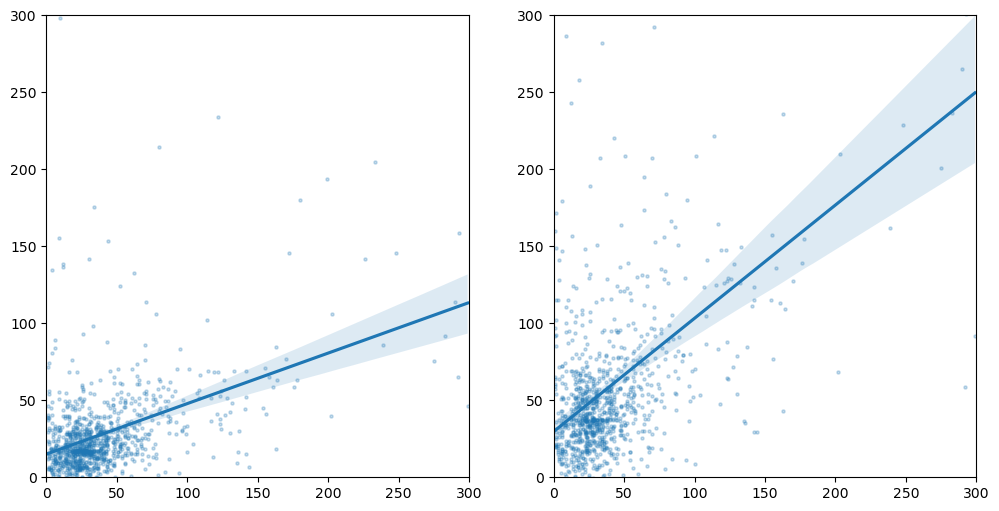

In [16]:
# Statsmodels
yactual = streetparking_df.spaces.values
ypred_lm = mod_lm.predict(streetparking_df)
ypred_calc = EstSpaces.calculate_spaces(streetparking_df.length, streetparking_df.intcount)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.regplot(x=yactual, y=ypred_lm, scatter=True, ax=axes[0], scatter_kws={'s':5, 'alpha':0.25})
sns.regplot(x=yactual, y=ypred_calc, scatter=True, ax=axes[1], scatter_kws={'s':5, 'alpha':0.25})
for ax in axes:
    ax.set_ylim(0, 300)
    ax.set_xlim(0, 300)

print('MAPE:', MAPE(yactual, ypred_lm))
print('MAPE:', MAPE(yactual, ypred_calc))

In [17]:
# mod_lm.predict(street_data)
full_streetdata_df = street_data[['length','intcount']].join((gdf_mgra.geometry.area / 43560).to_frame('acres'))
mod_lm.predict(full_streetdata_df)

MGRA
1        103.814844
2         38.691513
3         50.763883
4         19.605624
5         34.246620
            ...    
24317     -0.005817
24318     66.926219
24319   -355.317069
24320   -429.616506
24321     34.381580
Length: 24321, dtype: float64

# Expected parking costs

- district_dummy = {if outside district gets 1, elseif no space zones in hull get 0, else 1}
  - no space zones = concave hull - parking cost zones
- distance_dummy = if dist <= max_dist
- dummy = distance_dummy * district_dummy
- $numerator_i = e^{dist * \beta_{walk}} * spaces * cost * dummy$
- $denominator_i = e^{dist * \beta_{walk}} * spaces * dummy$

Expected parking cost = $\frac{\sum numerator_i}{\sum denominator_i}$

In [204]:
importlib.reload(sys.modules['parking.expected_cost'])
from parking.expected_cost import ExpectedParkingCost

EPC = ExpectedParkingCost()

# Estimate spaces
estimated_spaces = EstSpaces.estimate_spaces(street_data, gdf_mgra, parking_df, method='calc')
costs_df = EPC.prepare_cost_table(imputed_df, estimated_spaces, parking_districts)
district_ids = parking_districts[parking_districts.is_prkdistrict].index.unique()
geos = gdf_mgra.loc[district_ids].geometry

if 'dist_df' not in locals():
    dist_df = EPC.pre_calc_dist(geos)

if 'exp_costs' not in locals():
    exp_costs = [EPC.expected_parking_cost(x, costs_df, dist_df) for x in tqdm(geos.index)]

# # Some example zones that are both in and not in the cost data
# zones = []
# zones += random.sample(costs_df.index.to_list(), 10)
# zones += random.sample(range(1, 24333), 5)
# zones = set(zones)

# for i in zones:
#     print(f"dest {i}:  ${round(EPC.expected_parking_cost(i, 'hourly', costs_df, dist_df), 2)}")

100%|██████████| 3321/3321 [02:46<00:00, 19.89it/s]


In [250]:
exp_prkcosts_df = pd.DataFrame(exp_costs).set_index('index')
cols = exp_prkcosts_df.columns

exp_prkcosts_df = exp_prkcosts_df.rename(columns={x: 'exp_' + x for x in exp_prkcosts_df.columns})
exp_prkcosts_df = exp_prkcosts_df.reindex(gdf_mgra.index)
exp_prkcosts_gdf = exp_prkcosts_df.join(gdf_mgra[['geometry']])
exp_prkcosts_df = exp_prkcosts_df.fillna(0)
exp_prkcosts_df.to_csv('./output/expected_parking_costs.csv')

exp_prkcosts_df

,exp_hourly,exp_daily,exp_monthly
MGRA,,,
1,0.00000,0.000000,0.000000
2,3.71673,18.070008,138.101772
3,0.00000,0.000000,0.000000
4,0.00000,0.000000,0.000000
5,0.00000,0.000000,0.000000
...,...,...,...
24317,0.00000,0.000000,0.000000
24318,0.00000,0.000000,0.000000
24319,0.00000,0.000000,0.000000


In [248]:
# Plot paid parking zones
# map = folium.Map(location=[32.7521765494396, -117.11514883606573], tiles="Stamen Toner", zoom_start=9)
# folium.Choropleth(data=exp_prkcost_gdf.reset_index(),
#                   geo_data=exp_prkcost_gdf.reset_index(),                           # data
#                   columns=['MGRA','exp_prkcost'],   # [key, value]
#                   key_on='feature.properties.MGRA',
#                   fill_column = 'exp_prkcost',
#                   fill_color= 'YlOrRd',                     # cmap
#                   line_weight=0.1,                       # line wight (of the border)
#                   line_opacity=0.5,                      # line opacity (of the border)
#                   legend_name='Expected parking costs').add_to(map)    # name on the legend color bar
# map.save('output/expected_parking_costs.html')

for cost_type in ['exp_hourly', 'exp_daily', 'exp_monthly']:
    gdf = gpd.GeoDataFrame(exp_prkcost_gdf[['geometry', cost_type]].dropna().reset_index())
    cost_lab = cost_type.replace("exp_", "")
    
    # Plot paid parking zones
    map = folium.Map(location=[32.7521765494396, -117.11514883606573], tiles="Stamen Toner", zoom_start=9)
    folium.Choropleth(data=gdf,
                        geo_data=gdf,                           # data
                        columns=['MGRA', cost_type],   # [key, value]
                        key_on='feature.properties.MGRA',
                        fill_column = cost_type,
                        fill_color= 'YlOrRd',                     # cmap
                        line_weight=0.1,                       # line wight (of the border)
                        line_opacity=0.5,                      # line opacity (of the border)
                        legend_name=f'Expected {cost_lab} parking costs').add_to(map)    # name on the legend color bar
    map.save(f'output/expected_parking_costs_{cost_lab}.html')

